In [1]:
from google.transit import gtfs_realtime_pb2
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 500)

# Initialisation

In [2]:
# Trips and routes.
trips = pd.read_csv('./data/2-working-data/tvarbanan-trips.csv', index_col=0)
trips.trip_id = trips.trip_id.astype(str)
trips = trips.drop(columns=['service_id', 'trip_headsign', 'agency_id', 
                            'shape_id', 'route_type', 'route_long_name', 
                            'route_short_name'])

# Filter only Tvärbanan
trips_selected = trips[trips.route_desc.str.contains('Tvär') == True]
trips_selected.sample(5)

route_id            trip_id  direction_id route_desc
239   9011001003000000  14010000582482734             1  Tvärbanan
641   9011001003000000  14010000581056756             0  Tvärbanan
1026  9011001003000000  14010000586210243             1  Tvärbanan
1573  9011001003000000  14010000586387020             0  Tvärbanan
1750  9011001003000000  14010000602202040             1  Tvärbanan

/Users/ivo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


stop_id            stop_name  direction  \
10916  9022001004547002        Solna centrum          2   
11105  9022001004543001  Sundbybergs centrum          1   
11106  9022001004543002  Sundbybergs centrum          2   
12760  9022001004505001                Linde          1   
12761  9022001004505002                Linde          2   

                        geometry  
10916  POINT (17.99627 59.36137)  
11105  POINT (17.97045 59.36087)  
11106  POINT (17.97036 59.36081)  
12760  POINT (18.06386 59.29330)  
12761  POINT (18.06340 59.29323)

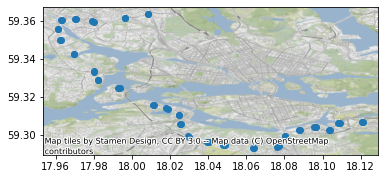

In [3]:
# Stops selected for Tvärbanan
stops = pd.read_csv('./data/2-working-data/tvarbanan-stops.csv', index_col=0)
stops.stop_id = stops.stop_id.astype(str)

# Change to GeoDataFrame
stops['geometry'] = stops.apply(lambda x: Point(x.stop_lon, x.stop_lat), axis=1)
stops = stops.drop(columns=['location_type', 'stop_lat', 'stop_lon', 'platform_code', 'parent_station'])
stops = gpd.GeoDataFrame(stops, crs='EPSG:4326')

# Plot out and show stops
ax = stops.plot()
cx.add_basemap(ax, crs=stops.crs)

stops.head()

In [57]:
# Read in all csv's following a GLOB pattern.
tu_df = pd.concat([
    pd.read_csv(csv_file, index_col=0) 
    for csv_file in glob('./data/3-cleaned-data/TU-202106*.csv')[:14]])

# Allow for merging below
tu_df.trip_id = tu_df.trip_id.astype(str)
tu_df.stop_id = tu_df.stop_id.astype(str)

# Interpret timestamps
tu_df.timestamp    = pd.to_datetime(tu_df.timestamp, unit='s')
tu_df.arrival_ts   = pd.to_datetime(tu_df.arrival_ts, unit='s')
tu_df.departure_ts = pd.to_datetime(tu_df.departure_ts, unit='s')

# Not necessary, it seems like trip_id is unique. 
# tu_df['week'] = tu_df.arrival_ts.dt.isocalendar().week

# Reset records without valid timestamp, eg, 1970 unix zero.
tu_df.loc[tu_df.arrival_ts.dt.year == 1970, 'arrival_ts'] = None
tu_df.loc[tu_df.departure_ts.dt.year == 1970, 'departure_ts'] = None

# Calculate true departure times
tu_df['arrival_ts_sched']   = tu_df.arrival_ts - pd.to_timedelta(tu_df.arrival_delay, unit='s')
tu_df['departure_ts_sched'] = tu_df.departure_ts - pd.to_timedelta(tu_df.departure_delay, unit='s')

# Output head.
tu_df.head()

/Users/ivo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


timestamp            trip_id  rel           stop_id  \
0 2021-06-28 09:15:33  14010000586206263    0  9022001007611003   
1 2021-06-28 09:27:01  14010000590747905    0  9022001004541001   
2 2021-06-28 09:27:01  14010000590747905    0  9022001004543001   
3 2021-06-28 09:27:01  14010000590747905    0  9022001004545001   
4 2021-06-28 09:27:01  14010000590747905    0  9022001004547001   

           arrival_ts  arrival_delay        departure_ts  departure_delay  \
0 2021-06-28 09:15:34           -146 2021-06-28 09:15:34             -146   
1 2021-06-28 09:15:35           -145 2021-06-28 09:17:58               -2   
2 2021-06-28 09:18:44            -46 2021-06-28 09:19:23               -7   
3 2021-06-28 09:20:49            -41 2021-06-28 09:21:21               -9   
4 2021-06-28 09:23:02            -58 2021-06-28 09:23:44              -16   

   week    arrival_ts_sched  departure_ts_sched  
0    26 2021-06-28 09:18:00 2021-06-28 09:18:00  
1    26 2021-06-28 09:18:00 2021-06-28 09:18:00  
2    26 2021-06-28 09:19:30 2021-06-28 09:19:30  
3    26 2021-06-28 09:21:30 2021-06-28 09:21:30  
4    26 2021-06-28 09:24:00 2021-06-28 09:24:00

In [61]:
# Merge trips, routes and stop-data into TripUpdate_df. 
tu_df_merged = tu_df.merge(stops, how='left', on='stop_id')
tu_df_merged = tu_df_merged.merge(trips, how='left', on='trip_id')
tu_df_merged['trip_date'] = tu_df_merged.arrival_ts
tu_df_merged[['timestamp', 'trip_id', 'stop_id', 'arrival_delay', 'direction_id',
              'departure_delay', 'route_desc', 'week', 'stop_name']].sample(5)

timestamp            trip_id           stop_id  \
5737197 2021-06-03 12:19:50  14010000586634487  9022001004515001   
7131922 2021-06-02 20:38:17  14010000574686550  9022001004507002   
8558022 2021-06-12 12:52:57  14010000574853486  9022001004503002   
6009648 2021-06-03 17:15:00  14010000581063545  9022001004541001   
1015865 2021-06-14 11:45:52  14010000586386875  9022001004503001   

         arrival_delay  direction_id  departure_delay route_desc  week  \
5737197            -39           1.0                0  Tvärbanan    22   
7131922             59           0.0               97  Tvärbanan    22   
8558022              3           0.0               46  Tvärbanan    23   
6009648           -123           1.0                9  Tvärbanan    22   
1015865             32           1.0               89  Tvärbanan    24   

           stop_name  
5737197  Liljeholmen  
7131922   Valla torg  
8558022       Globen  
6009648  Bällsta bro  
1015865       Globen

In [53]:
# Apply categorical sorting to Stop Name from North to South
sort_ns = tu_df_merged[tu_df_merged.trip_id=='14010000580361393']
sort_ns = sort_ns.groupby('stop_id').apply(lambda x: x.loc[x.timestamp.idxmax()])
sort_ns = sort_ns.sort_values('arrival_ts')
print(sort_ns.stop_name.to_list())

['Solna station', 'Solna centrum', 'Solna Business Park', 'Sundbybergs centrum', 'Bällsta bro', 'Karlsbodavägen', 'Norra Ulvsunda', 'Johannesfred', 'Alvik', 'Alviks strand', 'Stora Essingen', 'Gröndal', 'Trekanten', 'Liljeholmen', 'Årstadal', 'Årstaberg', 'Årstafältet', 'Valla torg', 'Linde', 'Globen', 'Gullmarsplan', 'Mårtensdal', 'Luma', 'Sickla kaj', 'Sickla udde', 'Sickla']


# Delay

From: https://gtfs.org/realtime/reference/#message-stoptimeupdate

* Positive is a delay
* Negative is ahead of schedule

Direction_id: 
* 0.0 Solna-Sickla (south-facing)
* 1.0 Sickla-Solna (north-facing)

### Example

In [54]:
# EXAMPLE: Delay details of a random trip on a random day at 14:51. 
single = tu_df_merged[tu_df_merged.trip_id == '14010000586634258']
single = single.groupby('stop_id').apply(lambda x: x.loc[x.timestamp.idxmax()])
single = single.reset_index(drop=True)

# Apply sorting system
single.stop_name = pd.Categorical(single.stop_name, sort_ns.stop_name)
single.sort_values('stop_name', ascending=False).head()

timestamp            trip_id  rel           stop_id  \
25 2021-06-17 10:58:53  14010000586634258    0  9022001007611002   
16 2021-06-17 10:58:53  14010000586634258    0  9022001004533001   
15 2021-06-17 11:00:23  14010000586634258    0  9022001004531001   
14 2021-06-17 11:02:24  14010000586634258    0  9022001004529001   
13 2021-06-17 11:04:51  14010000586634258    0  9022001004527001   

            arrival_ts  arrival_delay        departure_ts  departure_delay  \
25 2021-06-17 10:46:01            -89 2021-06-17 10:47:20              -10   
16 2021-06-17 10:48:51            -39 2021-06-17 10:49:32                2   
15 2021-06-17 10:50:33            -27 2021-06-17 10:51:32               32   
14 2021-06-17 10:52:52             -8 2021-06-17 10:52:52               -8   
13 2021-06-17 10:54:24            -36 2021-06-17 10:54:24              -36   

      arrival_ts_sched  departure_ts_sched    stop_name  direction  \
25 2021-06-17 10:47:30 2021-06-17 10:47:30       Sickla        2.0   
16 2021-06-17 10:49:30 2021-06-17 10:49:30  Sickla udde        1.0   
15 2021-06-17 10:51:00 2021-06-17 10:51:00   Sickla kaj        1.0   
14 2021-06-17 10:53:00 2021-06-17 10:53:00         Luma        1.0   
13 2021-06-17 10:55:00 2021-06-17 10:55:00   Mårtensdal        1.0   

                       geometry      route_id  direction_id route_desc  \
25  POINT (18.121004 59.306828)  9.011001e+15           1.0  Tvärbanan   
16  POINT (18.108313 59.306292)  9.011001e+15           1.0  Tvärbanan   
15  POINT (18.103485 59.302659)  9.011001e+15           1.0  Tvärbanan   
14  POINT (18.095406 59.304202)  9.011001e+15           1.0  Tvärbanan   
13   POINT (18.08764 59.302579)  9.011001e+15           1.0  Tvärbanan   

             trip_date  
25 2021-06-17 10:46:01  
16 2021-06-17 10:48:51  
15 2021-06-17 10:50:33  
14 2021-06-17 10:52:52  
13 2021-06-17 10:54:24

In [62]:
# Group by trip and stop and then sort by timestamp to select latest update
groupall = tu_df_merged.groupby(['direction_id', 'trip_id', 'stop_id']).apply(
    lambda x: x.loc[x.timestamp.idxmax()] if len(x) > 0 else None)

# Show examples
groupall = groupall.drop(columns=['direction_id', 'trip_id', 'stop_id'])
groupall.sample(3)

timestamp  rel  \
direction_id trip_id           stop_id                                     
1.0          14010000590744139 9022001004537001 2021-06-29 21:18:16    0   
0.0          14010000586207802 9022001004503002 2021-06-29 12:16:05    0   
             14010000590748984 9022001004541002 2021-06-29 13:53:32    0   

                                                         arrival_ts  \
direction_id trip_id           stop_id                                
1.0          14010000590744139 9022001004537001 2021-06-29 21:08:06   
0.0          14010000586207802 9022001004503002 2021-06-29 12:05:31   
             14010000590748984 9022001004541002 2021-06-29 13:43:26   

                                                 arrival_delay  \
direction_id trip_id           stop_id                           
1.0          14010000590744139 9022001004537001             66   
0.0          14010000586207802 9022001004503002             61   
             14010000590748984 9022001004541002            -94   

                                                       departure_ts  \
direction_id trip_id           stop_id                                
1.0          14010000590744139 9022001004537001 2021-06-29 21:08:38   
0.0          14010000586207802 9022001004503002 2021-06-29 12:06:21   
             14010000590748984 9022001004541002 2021-06-29 13:45:01   

                                                 departure_delay  week  \
direction_id trip_id           stop_id                                   
1.0          14010000590744139 9022001004537001               98    26   
0.0          14010000586207802 9022001004503002              111    26   
             14010000590748984 9022001004541002                1    26   

                                                   arrival_ts_sched  \
direction_id trip_id           stop_id                                
1.0          14010000590744139 9022001004537001 2021-06-29 21:07:00   
0.0          14010000586207802 9022001004503002 2021-06-29 12:04:30   
             14010000590748984 9022001004541002 2021-06-29 13:45:00   

                                                 departure_ts_sched  \
direction_id trip_id           stop_id                                
1.0          14010000590744139 9022001004537001 2021-06-29 21:07:00   
0.0          14010000586207802 9022001004503002 2021-06-29 12:04:30   
             14010000590748984 9022001004541002 2021-06-29 13:45:00   

                                                      stop_name  direction  \
direction_id trip_id           stop_id                                       
1.0          14010000590744139 9022001004537001  Norra Ulvsunda        1.0   
0.0          14010000586207802 9022001004503002          Globen        2.0   
             14010000590748984 9022001004541002     Bällsta bro        2.0   

                                                                    geometry  \
direction_id trip_id           stop_id                                         
1.0          14010000590744139 9022001004537001   POINT (17.962553 59.34979)   
0.0          14010000586207802 9022001004503002  POINT (18.077091 59.294214)   
             14010000590748984 9022001004541002  POINT (17.962887 59.360691)   

                                                     route_id route_desc  \
direction_id trip_id           stop_id                                     
1.0          14010000590744139 9022001004537001  9.011001e+15  Tvärbanan   
0.0          14010000586207802 9022001004503002  9.011001e+15  Tvärbanan   
             14010000590748984 9022001004541002  9.011001e+15  Tvärbanan   

                                                          trip_date  
direction_id trip_id           stop_id                               
1.0          14010000590744139 9022001004537001 2021-06-29 21:08:06  
0.0          14010000586207802 9022001004503002 2021-06-29 12:05:31  
             14010000590748984 9022001004541002 2021-06-29 13:43:26

<AxesSubplot:ylabel='Frequency'>

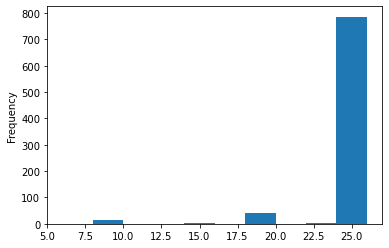

In [69]:
groupall.groupby(['trip_id']).size().plot(kind='hist')

### Departure delay per station per trip

In [238]:
groupall_filtered = (groupall[groupall.departure_delay < 450])

delays_north = groupall_filtered.loc[1.0].pivot_table('departure_delay', 'stop_name', 'trip_id')
delays_south = groupall_filtered.loc[0.0].pivot_table('departure_delay', 'stop_name', 'trip_id')

delays_north = delays_north.fillna(0)
delays_south = delays_south.fillna(0)

delays_north.index = pd.Categorical(delays_north.index, sort_ns.stop_name)
delays_south.index = pd.Categorical(delays_south.index, sort_ns.stop_name)

delays_north = delays_north.sort_index(ascending=False)
delays_south = delays_south.sort_index(ascending=True)

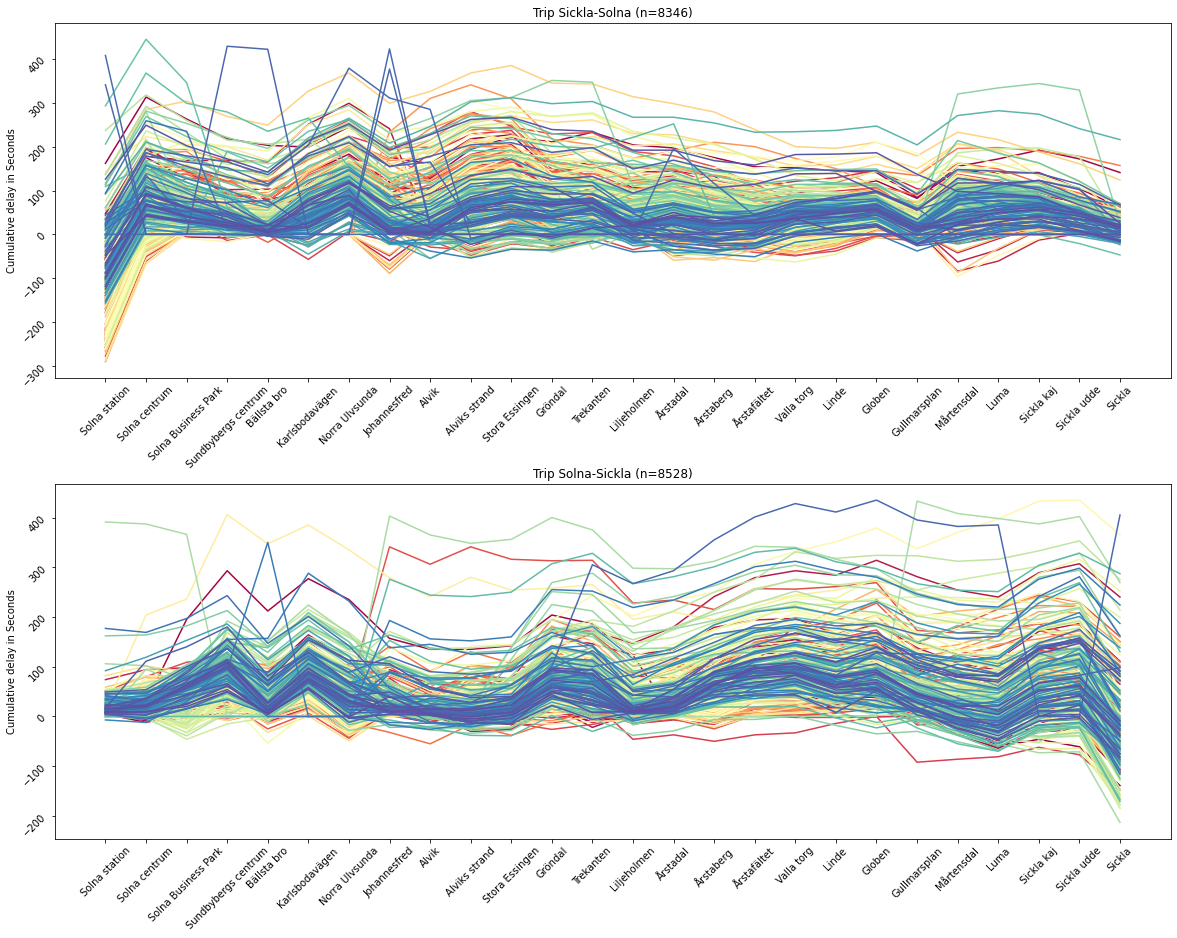

In [237]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 15))

sns.lineplot(data=delays_north,
             ax=axs[0],
             legend=False,
             dashes=False,
             palette='Spectral', 
             sort=False)
axs[0].set_title(f"""Trip Sickla-Solna (n={delays_south.size})""")
axs[0].set_ylabel('Cumulative delay in Seconds')
axs[0].tick_params(labelrotation=45)

sns.lineplot(data=delays_south,
             ax=axs[1],
             legend=False,
             dashes=False,
             palette='Spectral', 
             sort=False)
axs[1].set_title(f"""Trip Solna-Sickla (n={delays_north.size})""")
axs[1].set_ylabel('Cumulative delay in Seconds')
axs[1].tick_params(labelrotation=45)

fig.subplots_adjust(hspace=0.3)

### Dwell Time per station distribution

departure_delay      dwell
stop_name                                      
Alvik                      35.852484  73.355590
Alviks strand              57.854232  35.224138
Bällsta bro                36.909238  69.948136
Globen                     82.989028  43.746082
Gröndal                    72.539185  44.449843
Gullmarsplan               42.399687  76.608150
Johannesfred               42.279503  49.281056
Karlsbodavägen             78.706645  38.247974
Liljeholmen                45.418495  88.711599
Linde                      71.735110  39.020376
Luma                       60.383046  17.312402
Mårtensdal                 58.976489   8.782132
Norra Ulvsunda             76.811994  36.836305
Sickla                      1.422292  52.478807
Sickla kaj                 69.739403  43.452119
Sickla udde                60.866562  40.594976
Solna Business Park        62.917342  37.066451
Solna centrum              60.312804  44.288493
Solna station             -29.904376  55.878444
Stora Essingen             64.937304  39.476489
Sundbybergs centrum        68.599676  26.197731
Trekanten                  75.615987  37.416928
Valla torg                 72.653605  43.460815
Årstaberg                  57.979624  49.153605
Årstadal                   55.890282  43.203762
Årstafältet                67.249216  40.540752

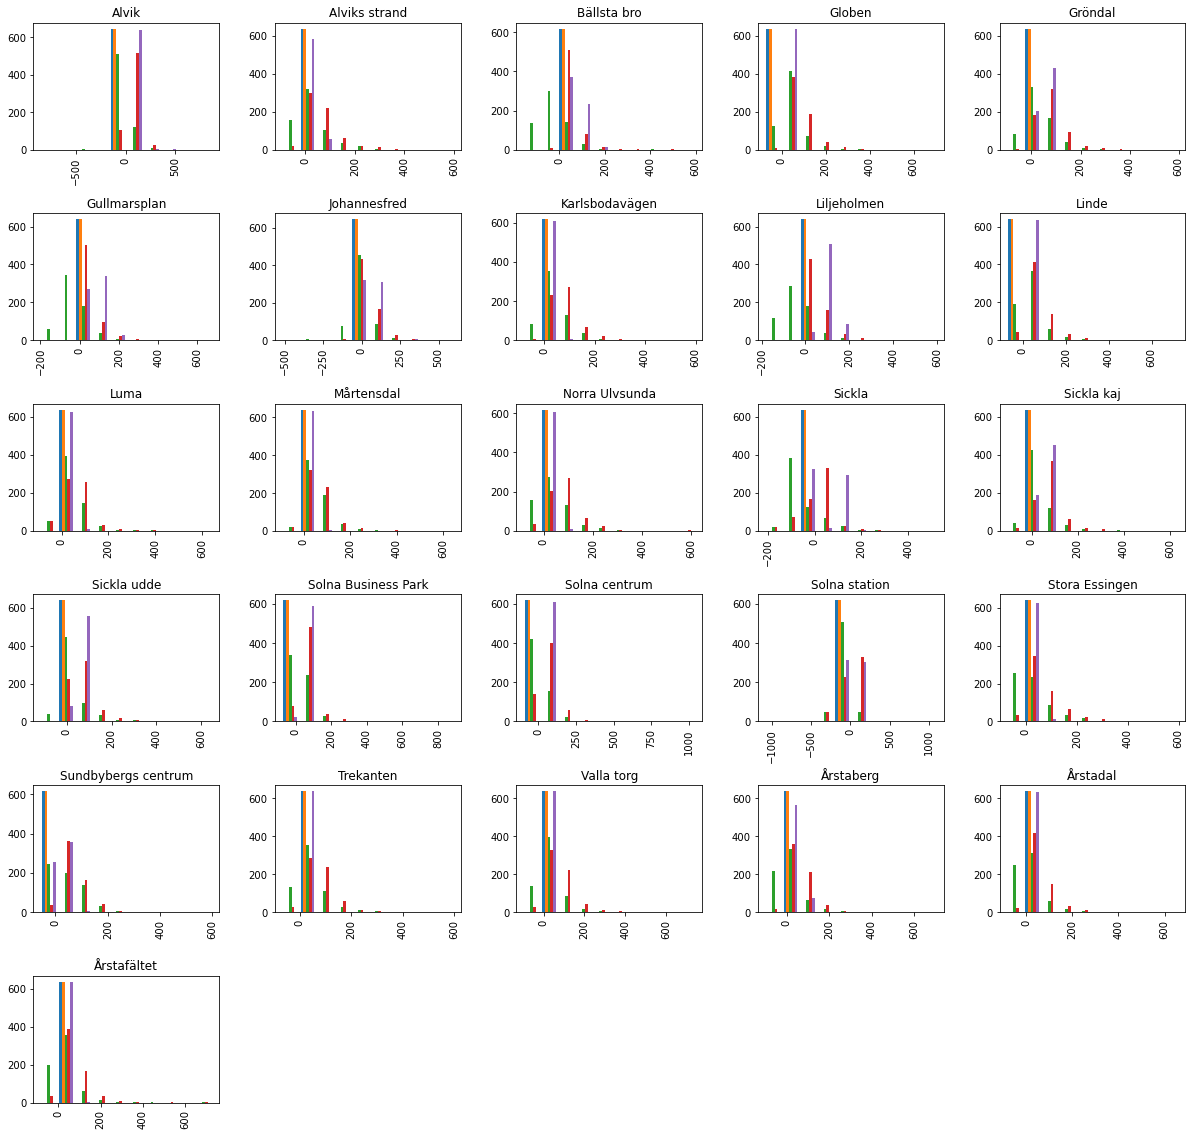

In [272]:
dwell_time = groupall.reset_index()
dwell_time['dwell'] = (dwell_time.departure_delay - dwell_time.arrival_delay)#.dt.seconds
dwell_time.hist(by=dwell_time['stop_name'], figsize=(20,20))

dwell_time.groupby('stop_name').mean()[['departure_delay', 'dwell']]

### Travel time between stations
* Calculate time to travel between two stops, time between departure time and arrival time in seconds.
* Compare this time to the scheduled travel time (departure_ts-departure_delay)

In [71]:
row = pd.read_csv('./data/2-working-data/routes_row.csv')
row.start_stop_id = row.start_stop_id.astype(str)
row.end_stop_id = row.start_stop_id.astype(str)
row['quality'] = 100 - 0*row.A - 0.5*row.B - 1*row.C
row.head(4)

direction_id  order                start     start_stop_id  \
0           0.0      1        Solna station  9022001004549002   
1           0.0      2        Solna centrum  9022001004547002   
2           0.0      3  Solna Business Park  9022001004545002   
3           0.0      4  Sundbybergs centrum  9022001004543002   

                   end       end_stop_id   A    B    C  quality  
0        Solna centrum  9022001004549002   0  100    0     50.0  
1  Solna Business Park  9022001004547002   0   75   25     37.5  
2  Sundbybergs centrum  9022001004545002  40    0   60     40.0  
3          Bällsta bro  9022001004543002   0    0  100      0.0

In [72]:
groupweek = tu_df_merged.groupby(['trip_id', 'stop_id']).apply(
    lambda x: x.loc[x.timestamp.idxmax()] if len(x) > 0 else None)
groupweek = groupweek.reset_index(drop=True)

In [78]:
# Lambda Function to merge two stop records with arrival and departure time 
#  into one single row with a point-to-point trip with departure & arrival time.

def stops_to_p2p_trips(trip):
    trip = trip.reset_index(drop=True)
    trip_out = trip[[
        'trip_id', 'stop_id', 'departure_ts', 'departure_ts_sched'
    ]]

    trip_out = trip_out.merge(row[[
        'order', 'start_stop_id', 'end_stop_id', 'start', 'end', 'A', 'B', 'C',
        'quality'
    ]],
                              how='left',
                              left_on='stop_id',
                              right_on='start_stop_id')

    trip_out = trip_out.merge(
        trip[['arrival_ts', 'arrival_ts_sched', 'stop_id']],
        how='left',
        left_on='end_stop_id',
        right_on='stop_id',
        suffixes=('', '_to'),
    )

    return trip_out  #.sort_values('order')

In [79]:
p2p_trips = groupweek.groupby(['trip_id']).apply(stops_to_p2p_trips)
p2p_trips.sample(5)

trip_id           stop_id        departure_ts  \
trip_id                                                                         
14010513428021170 4   14010513428021170  9022001004543001 2021-06-17 03:33:40   
14010000582483419 11  14010000582483419  9022001004523002 2021-06-13 13:18:48   
14010000590743249 4   14010000590743249  9022001004561002 2021-06-28 16:22:00   
14010000586219590 7   14010000586219590  9022001004515001 2021-06-29 14:19:31   
14010000586384788 15  14010000586384788  9022001004531002 2021-06-17 03:41:57   

                      departure_ts_sched  order     start_stop_id  \
trip_id                                                             
14010513428021170 4  2021-06-17 03:29:00   22.0  9022001004543001   
14010000582483419 11 2021-06-13 13:18:00   10.0  9022001004523002   
14010000590743249 4  2021-06-28 16:22:00    NaN               NaN   
14010000586219590 7  2021-06-29 14:19:00   12.0  9022001004515001   
14010000586384788 15 2021-06-17 03:39:30   24.0  9022001004531002   

                           end_stop_id                start             end  \
trip_id                                                                       
14010513428021170 4   9022001004543001  Sundbybergs centrum     Bällsta bro   
14010000582483419 11  9022001004523002        Alviks strand  Stora Essingen   
14010000590743249 4                NaN                  NaN             NaN   
14010000586219590 7   9022001004515001          Liljeholmen        Årstadal   
14010000586384788 15  9022001004531002           Sickla kaj     Sickla udde   

                          A     B      C  quality          arrival_ts  \
trip_id                                                                 
14010513428021170 4     0.0   0.0  100.0      0.0 2021-06-17 03:33:28   
14010000582483419 11  100.0   0.0    0.0    100.0 2021-06-13 13:18:07   
14010000590743249 4     NaN   NaN    NaN      NaN                 NaT   
14010000586219590 7    65.0  15.0   20.0     72.5 2021-06-29 14:18:27   
14010000586384788 15    0.0   0.0  100.0      0.0 2021-06-17 03:41:15   

                        arrival_ts_sched        stop_id_to  
trip_id                                                     
14010513428021170 4  2021-06-17 03:29:00  9022001004543001  
14010000582483419 11 2021-06-13 13:18:00  9022001004523002  
14010000590743249 4                  NaT               NaN  
14010000586219590 7  2021-06-29 14:19:00  9022001004515001  
14010000586384788 15 2021-06-17 03:39:30  9022001004531002

In [ ]:
p2p_trips['scheduled_length'] = (p2p_trips.arrival_ts_sched - p2p)

# ToDo

* Average stop delay
* Variance in stop delay
* Seeing how much prediction of stop delay is actually realistic: is it too pessimistic or too optimistic? Is it accurate?
* Seeing if stops exist where trams always arrive early
